In [7]:
# ===========================================
# EDA (1): Descriptive Statistics for US Utility Stocks
# ===========================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
PERIOD = "5y"    # 5-year historical window
WINDOW_VOL = 20  # rolling volatility window
plt.style.use("seaborn-v0_8-whitegrid")

# ---------- DOWNLOAD ----------
data = yf.download(TICKERS, period=PERIOD, auto_adjust=True, progress=False)["Close"]

# Ensure business-day index (fill missing)
data = data.asfreq("B").ffill()



In [8]:
# ---------- DESCRIPTIVE STATISTICS ----------
desc_stats = data.describe().T  # Transpose for readability
desc_stats["skew"] = data.skew()
desc_stats["kurtosis"] = data.kurt()
print("=== Descriptive Statistics ===")
print(desc_stats.round(3))



=== Descriptive Statistics ===
         count    mean     std     min     25%     50%      75%      max  \
Ticker                                                                     
AEP     1304.0  83.602  11.698  63.398  74.281  80.597   90.358  118.190   
DUK     1304.0  93.875  13.022  71.708  84.839  89.915  100.505  125.560   
ED      1304.0  83.164  12.849  55.941  73.466  85.210   90.510  111.422   
EXC     1304.0  35.796   5.467  23.266  33.089  36.601   39.018   46.790   
SO      1304.0  67.449  13.018  47.458  57.368  64.679   76.839   96.420   

         skew  kurtosis  
Ticker                   
AEP     0.752    -0.280  
DUK     0.733    -0.466  
ED     -0.218    -0.717  
EXC    -0.392    -0.478  
SO      0.616    -0.777  


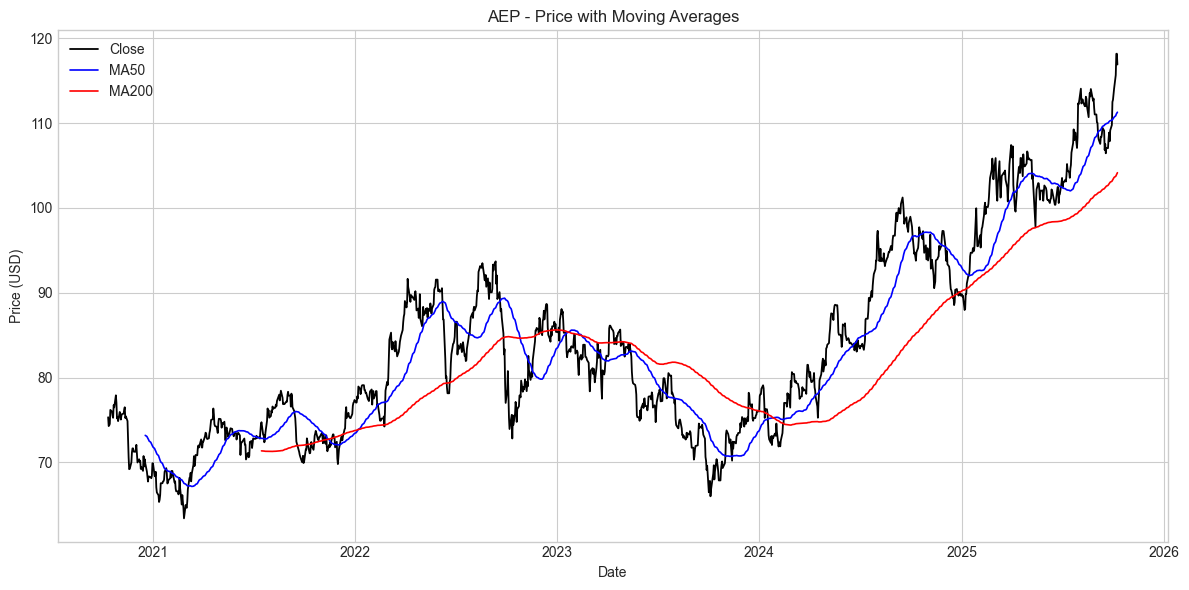

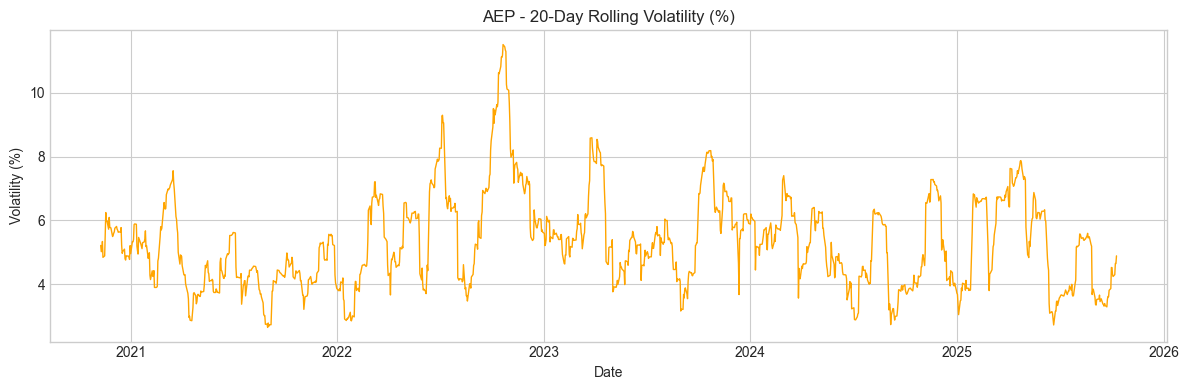

In [9]:
# ---------- TECHNICAL FEATURES ----------
ma50 = data.rolling(50).mean()
ma200 = data.rolling(200).mean()
volatility = data.pct_change().rolling(WINDOW_VOL).std() * np.sqrt(WINDOW_VOL) * 100  # % annualized volatility

# ---------- PLOT EXAMPLE (AEP) ----------
symbol = "AEP"
plt.figure(figsize=(12, 6))
plt.plot(data[symbol], label="Close", color="black", linewidth=1.3)
plt.plot(ma50[symbol], label="MA50", color="blue", linewidth=1.2)
plt.plot(ma200[symbol], label="MA200", color="red", linewidth=1.2)
plt.title(f"{symbol} - Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- VOLATILITY PLOT ----------
plt.figure(figsize=(12, 4))
plt.plot(volatility[symbol], color="orange", linewidth=1)
plt.title(f"{symbol} - 20-Day Rolling Volatility (%)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()

# ---------- SUMMARY TABLE (For Report) ----------
summary_table = desc_stats[["mean", "std", "min", "25%", "50%", "75%", "max", "skew", "kurtosis"]]
summary_table.round(3).to_csv("descriptive_stats.csv")  # Save for report

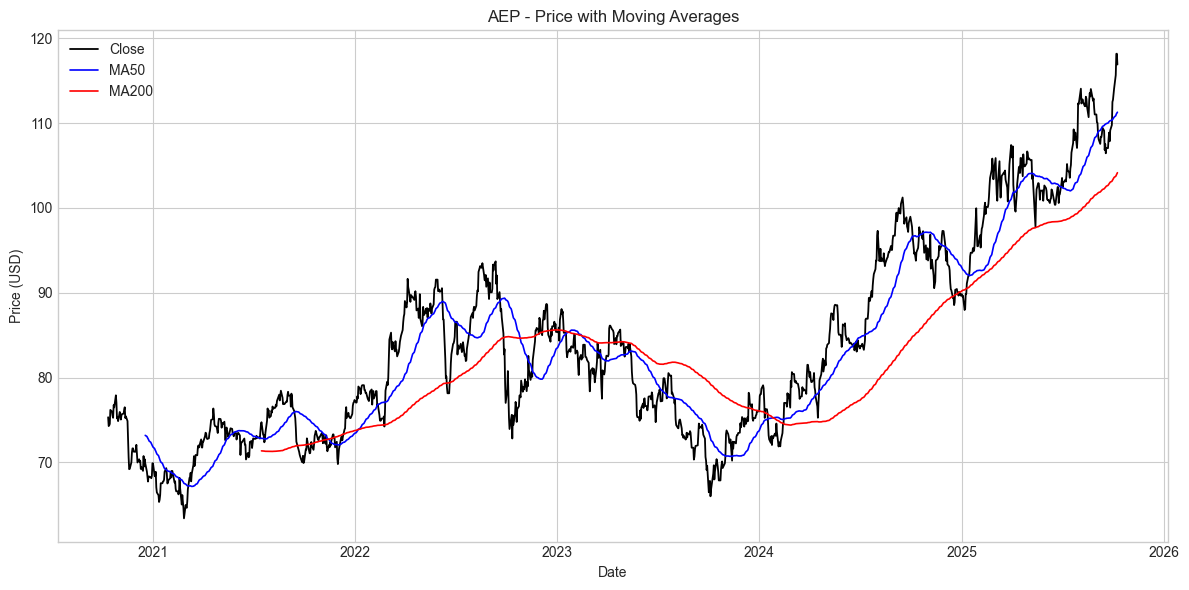

In [10]:
# ---------- PLOT EXAMPLE (AEP) ----------
symbol = "AEP"
plt.figure(figsize=(12, 6))
plt.plot(data[symbol], label="Close", color="black", linewidth=1.3)
plt.plot(ma50[symbol], label="MA50", color="blue", linewidth=1.2)
plt.plot(ma200[symbol], label="MA200", color="red", linewidth=1.2)
plt.title(f"{symbol} - Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()



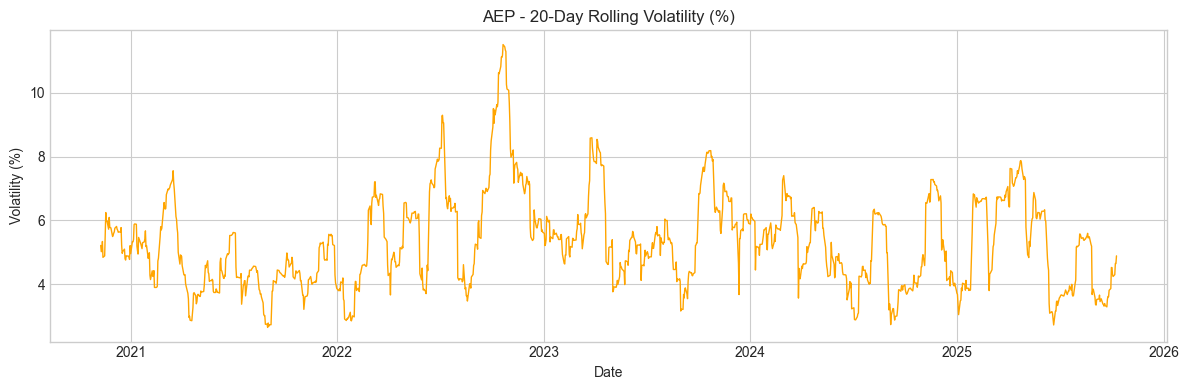

In [11]:
# ---------- VOLATILITY PLOT ----------
plt.figure(figsize=(12, 4))
plt.plot(volatility[symbol], color="orange", linewidth=1)
plt.title(f"{symbol} - 20-Day Rolling Volatility (%)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.tight_layout()
plt.show()


In [12]:
# ---------- SUMMARY TABLE (For Report) ----------
summary_table = desc_stats[["mean", "std", "min", "25%", "50%", "75%", "max", "skew", "kurtosis"]]
summary_table.round(3).to_csv("descriptive_stats.csv")  # Save for report

=== Missing Value Count (Before) ===
Ticker
AEP    0
DUK    0
ED     0
EXC    0
SO     0
dtype: int64


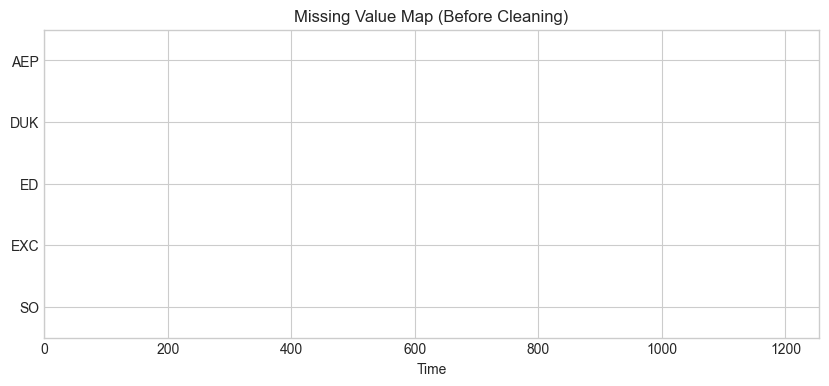


=== Missing Value Count (After FFill) ===
Ticker
AEP    0
DUK    0
ED     0
EXC    0
SO     0
dtype: int64

=== Outlier Count (|Z|>3) ===
AEP    13
DUK     9
ED     11
EXC    17
SO     13
dtype: int64


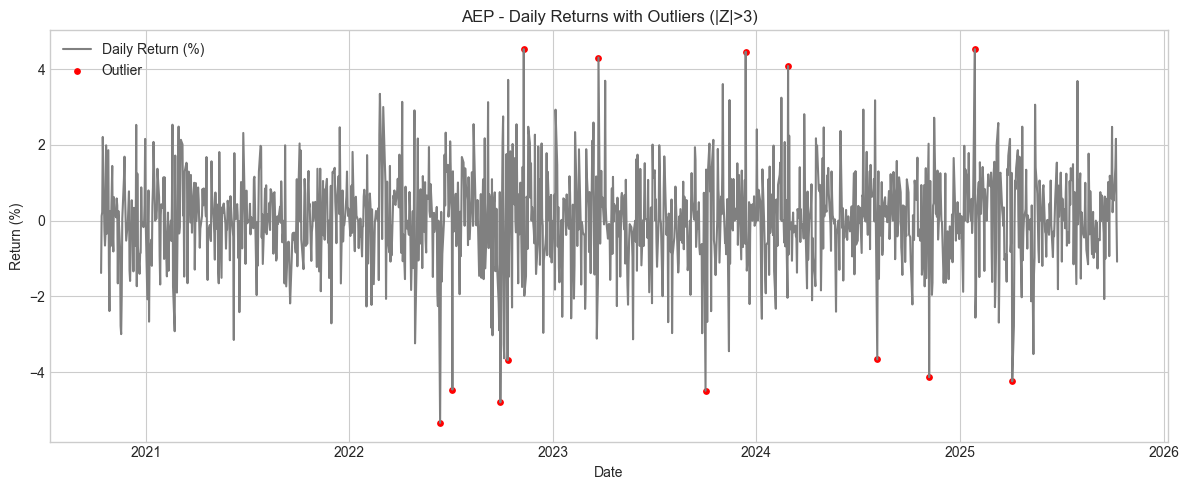

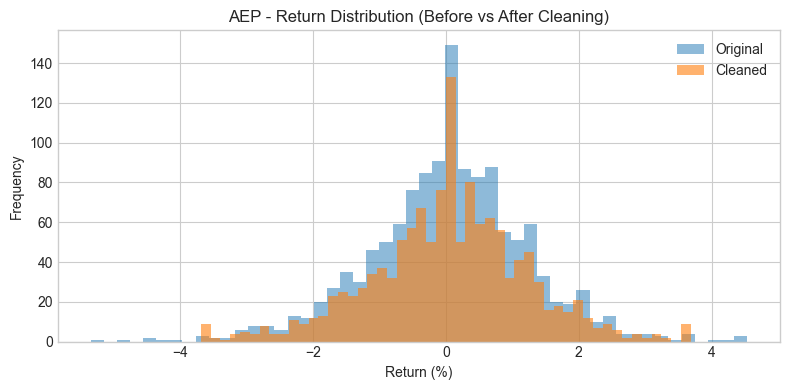

In [15]:
# ===========================================
# EDA (2): Check & Manage Missing Values and Outliers (Fixed)
# ===========================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
PERIOD = "5y"

# ---------- DOWNLOAD ----------
data = yf.download(TICKERS, period=PERIOD, auto_adjust=True, progress=False)["Close"]
data = data.sort_index()

# ---------- CHECK MISSING VALUES ----------
print("=== Missing Value Count (Before) ===")
print(data.isna().sum())

# Visualize missing data
plt.figure(figsize=(10, 4))
plt.imshow(data.isna().T, aspect="auto", cmap="gray_r")
plt.title("Missing Value Map (Before Cleaning)")
plt.yticks(range(len(data.columns)), data.columns)
plt.xlabel("Time")
plt.show()

# ---------- HANDLE MISSING VALUES ----------
# 1. Reindex to business days (ตลาดหุ้นหยุดเสาร์อาทิตย์)
data = data.asfreq("B")

# 2. Forward fill missing values
data_ffill = data.ffill()

print("\n=== Missing Value Count (After FFill) ===")
print(data_ffill.isna().sum())

# ---------- CHECK OUTLIERS ----------
returns = data_ffill.pct_change().dropna() * 100  # % returns

# คำนวณ Z-score แยกแต่ละหุ้นและคืนค่า DataFrame พร้อม index
z_scores = pd.DataFrame({
    col: np.abs(stats.zscore(returns[col], nan_policy='omit'))
    for col in returns.columns
}, index=returns.index)

outlier_mask = z_scores > 3
outlier_count = outlier_mask.sum()

print("\n=== Outlier Count (|Z|>3) ===")
print(outlier_count)

# ---------- VISUALIZE OUTLIERS ----------
symbol = "AEP"
mask = outlier_mask[symbol]

plt.figure(figsize=(12, 5))
plt.plot(returns[symbol], label="Daily Return (%)", color="gray")
plt.scatter(returns.index[mask],
            returns[symbol][mask],
            color="red", label="Outlier", s=15)
plt.title(f"{symbol} - Daily Returns with Outliers (|Z|>3)")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.tight_layout()
plt.show()

# ---------- HANDLE OUTLIERS ----------
# Strategy 1: Winsorization (clip to ±3σ per column)
returns_clean = returns.clip(
    lower=-3 * returns.std(),
    upper=3 * returns.std(),
    axis=1
)

# Strategy 2 (alternative): Replace outliers with rolling median
# returns_clean = returns.mask(outlier_mask, returns.rolling(5, center=True).median())

# ---------- CHECK CLEANED DISTRIBUTION ----------
plt.figure(figsize=(8, 4))
symbol = "AEP"
returns[symbol].hist(bins=50, alpha=0.5, label="Original")
returns_clean[symbol].hist(bins=50, alpha=0.6, label="Cleaned")
plt.title(f"{symbol} - Return Distribution (Before vs After Cleaning)")
plt.xlabel("Return (%)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
